### Import Packages

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cmath
from scipy.stats import qmc
dpi=300

### Implement Mandelbrot

In [2]:
def mandelbrot(z, c):
    """Calculates the next iteration of the mandelbrot set according to z^2 + c.

    Args:
        z (float): complex coordinate of the current iteration
        c (float): complex coordinate of starting point

    Returns:
        float: coordinate of next iteration in the complex plane.
    """
    return add_complex(square_complex(z), c)

def square_complex(z):
    """Calculates the square of a complex number: (a + bi)^2

    Args:
        z (float): complex number

    Returns:
        float: square of a complex number
    """
    return complex(z.real**2 - z.imag**2, 2*z.real*z.imag)

def add_complex(z1, z2):
    """Adds two complex numbers: a+bi + c+di = a+b + (b+d)i

    Args:
        z1 (float): complex number 1
        z2 (float): complex number 2

    Returns:
        float: result of z1 + z2
    """
    return complex(z1.real + z2.real, z1.imag + z2.imag)

def magnitude_complex(z):
    """Calculates the magnitude of  a complex number: |z| = sqrt(a^2 + b^2)

    Args:
        z (float): complex number

    Returns:
        float: magnitude of z
    """
    return np.sqrt(z.real**2 + z.imag**2)

In [3]:
def mandelbrot_plot(resolution, max_length_set, re_min, re_max, im_min, im_max):
	"""For a given resolution and range of real and imaginary numbers, a matrix is generated based on the number of iterations it takes to diverge (or not).

	Args:
		resolution (int): number of points in the real and imaginary range
		max_length_set (int): maximum number of iterations per starting point
		re_min (float): start of real range
		re_max (float): end or real range
		im_min (float): start of imaginary range
		im_max (float): end of imaginary range

	Returns:
		ndarray: matrix to visualise the mandelbrot set
	"""	
	real_range = np.linspace(re_min, re_max, resolution)
	imaginary_range = np.linspace(im_min, im_max, resolution)
	mat = np.full((resolution, resolution), max_length_set)

	# creates a contour plot in a horizontal direction.
	for i, im in enumerate(imaginary_range):
		for j, re in enumerate(real_range):
			c = complex(re, im)
			z = complex(0, 0)

			# checks after how many iteration the complex number diverges. if k=max_lengths_set, then no divergence.
			for k in range(max_length_set):
				z = mandelbrot(z, c)
				if magnitude_complex(z) > 2:
					mat[i, j] = k
					break

	return mat

#### Mandelbrot Plot Report
For the first plot of the report, we verify that our implementation of the Mandelbrot set works. We plot the Mandelbrot for different levels of the area boundaries, holding the length of the Mandelbrot set constant.

In [4]:
mandelplot = mandelbrot_plot(resolution=1000, max_length_set=100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25)
mandelplot_zoom = mandelbrot_plot(resolution=1000, max_length_set=100, re_min=0.18, re_max=0.43, im_min=0.46, im_max=0.71)
mandelplot_zoom2 = mandelbrot_plot(resolution=1000, max_length_set=100, re_min=0.228, re_max=0.258, im_min=0.562, im_max=0.592)

KeyboardInterrupt: 

In [ ]:
fig=  plt.figure(figsize=(10, 12), dpi=300)
gs = GridSpec(3, 2, fig)

# Main plot
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax1.imshow(mandelplot, cmap='hot', extent=[-2, 0.6, -1.25, 1.25])
ax1.set_ylabel('Imaginary numbers', fontsize=13)
ax1.set_xlabel('Real Numbers', fontsize=13)

# Zoom 1
ax2 = fig.add_subplot(gs[2, 0])
ax2.imshow(mandelplot_zoom, cmap='hot', extent=[0.18, 0.43, 0.46, 0.71], origin='lower')

# Zoom 2
ax3 = fig.add_subplot(gs[2, 1])
ax3.imshow(mandelplot_zoom2, cmap='hot', extent=[0.228, 0.258, 0.562, 0.592], origin='lower')

plt.tight_layout()
plt.show()

#### Mandelbrot Sampler
We implement four samplers to use for the Hit and Miss Integration:

1. **`UNIRAND`**:  
   This method performs uniform random sampling. It generates complex numbers by independently sampling the real and imaginary components uniformly within the specified bounds. This is suitable for simple, non-structured sampling across the domain.

2. **`OHC`**:  
   The Orthogonal Sampling method uses a Latin Hypercube with orthogonal sampling. This technique divides the domain into equally spaced regions, ensuring that each sample point falls into a unique orthogonal space, providing better coverage of the domain compared to simple random sampling.

3. **`LHC`**:  
   The Latin Hypercube Sampling method, similar to orthogonal sampling, divides the domain into regions for more systematic sampling. This method is particularly useful for reducing variance in the sampling process, resulting in a more even distribution across the bounds.

4. **`SOBEL`**:  
   The Sobol Sampling method generates low-discrepancy points that cover the space more uniformly than purely random methods. Sobol sampling is particularly effective for high-dimensional spaces and requires the number of samples to be a power of two for optimal results. This method is often used for quasi-Monte Carlo simulations due to its efficiency in covering the domain.


In [4]:
class MBSampler:
    """
    A class used to sample points of the mandelbrot set for montecarlo sampling.
    """
    def __init__(self, re_min, re_max, im_min, im_max):
        self.bounds = {
            "re_min": re_min,
            "re_max": re_max,
            "im_min": im_min,
            "im_max": im_max
        }

    def sample(self, method, num_samples, seed):
        match method:
            case "UNIRAND":
                return self.uniform_random(num_samples, seed)
            case "OHC":
                return self.orthogonal(num_samples, seed)
            case "LHC":
                return self.latin_hypercube(num_samples, seed)
            case "SOBEL":
                return self.sobol(num_samples, seed)
            case _:
                raise ValueError("Unknown Sampling Method")

    def uniform_random(self, num_samples, seed):
        np.random.seed(seed)
        c_re = np.random.uniform(self.bounds["re_min"], self.bounds["re_max"], num_samples)
        c_im = np.random.uniform(self.bounds["im_min"], self.bounds["im_max"], num_samples)
        c_array = c_re + 1j * c_im
        return c_array, c_re, c_im

    def _scaled_sampling(self, sampler, num_samples):
        samples = sampler.random(n=num_samples)
        scaled_samples = qmc.scale(samples,
                                   [self.bounds["re_min"], self.bounds["im_min"]],
                                   [self.bounds["re_max"], self.bounds["im_max"]])
        c_re = scaled_samples[:, 0]
        c_im = scaled_samples[:, 1]
        c_array = c_re + 1j * c_im
        return c_array, c_re, c_im

    def orthogonal(self, num_samples, seed):
        orth = qmc.LatinHypercube(d=2, strength=2, seed=seed)
        return self._scaled_sampling(orth, num_samples)

    def latin_hypercube(self, num_samples, seed):
        lhc = qmc.LatinHypercube(d=2, seed=seed)
        return self._scaled_sampling(lhc, num_samples)

    def sobol(self, num_samples, seed):
        if not (num_samples and (num_samples & (num_samples - 1)) == 0):
            raise ValueError("For Sobol sampling, num_samples must be a power of 2.")
        sobol = qmc.Sobol(d=2, seed=seed)
        return self._scaled_sampling(sobol, num_samples)


Both Orthogonal and Latin Hypercube use prime numbers to sample. Sobel requires a sample numbers $N$ to be represented as $2^N$. We implement a helper function below that creates a series of numbers that adhere to this requirement

In [5]:
def sobol_sample_sizes_generator(power=10):
    """Generates a list of the first 10 allowed numbers to be used for sobol sampling which are a power of 2.

    Args:
        power (int, optional): the highest power of 2 to be sampled from. Defaults to 10.

    Returns:
        list of int: a list of numbers from 2 to 2**power.
    """
    return [2**n for n in range(1,power+1)]

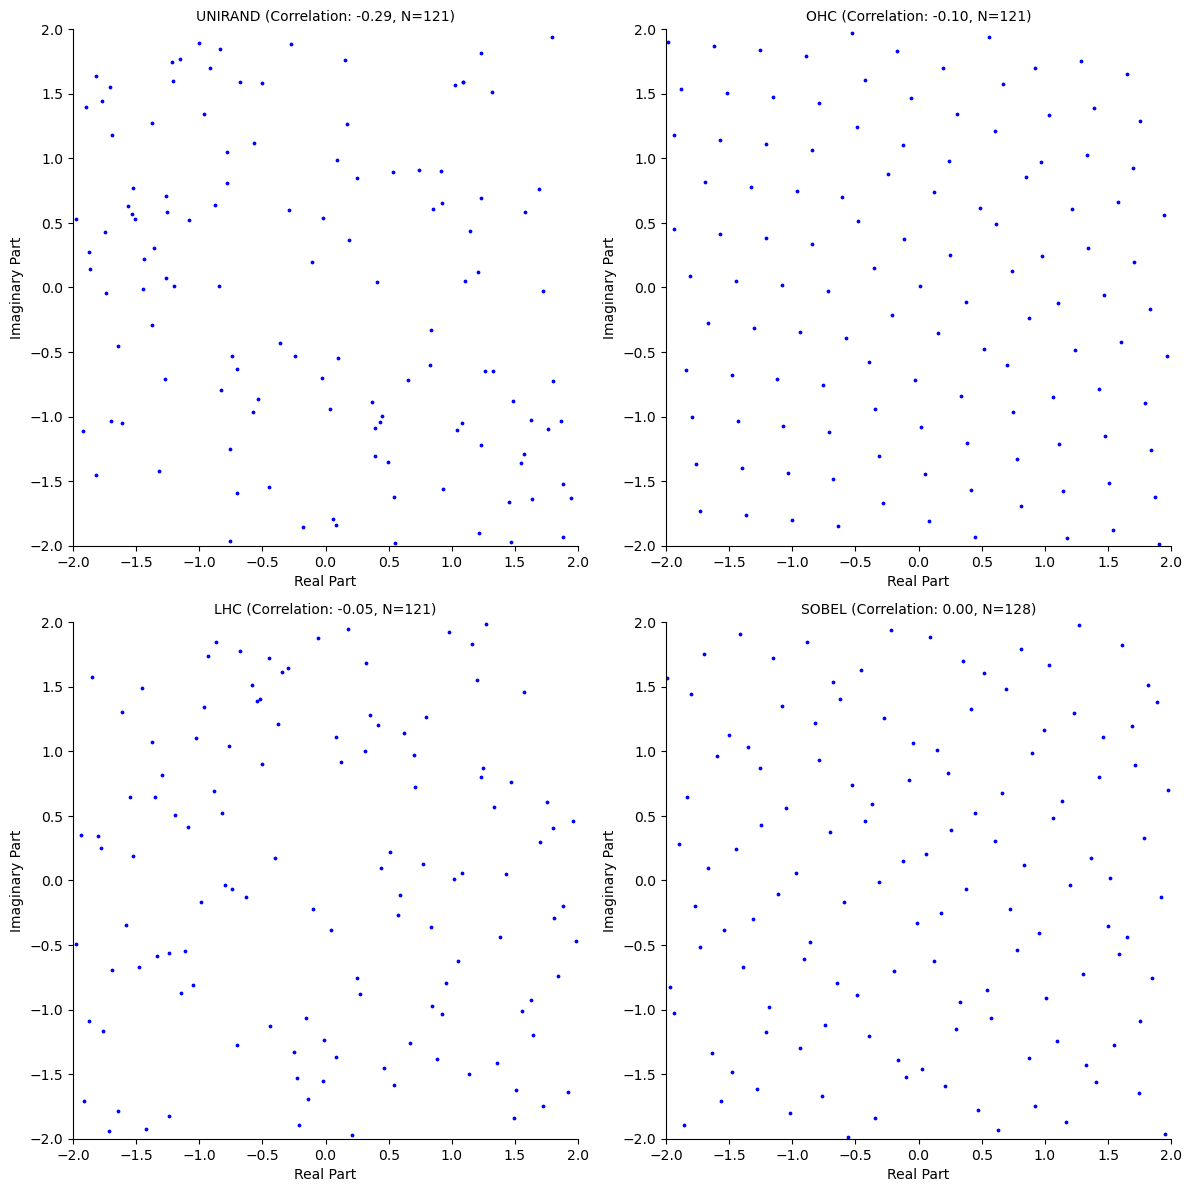

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Initialize MBSampler instance with desired bounds
sampler = MBSampler(re_min=-2, re_max=2, im_min=-2, im_max=2)
num_samples = {
    "UNIRAND": 121,
    "OHC": 121,
    "LHC": 121,
    "SOBEL": 128
}
seed = 42  # Random seed for reproducibility

# Sampling methods to test
methods = ["UNIRAND", "OHC", "LHC", "SOBEL"]
correlations = {}
samples = {}

# Generate samples and calculate correlations
for method in methods:
    c_array, c_re, c_im = sampler.sample(method, num_samples[method], seed)
    corr, _ = pearsonr(c_re, c_im)
    correlations[method] = corr
    samples[method] = (c_re, c_im)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i, method in enumerate(methods):
    c_re, c_im = samples[method]
    correlation = correlations[method]
    axs[i].scatter(c_re, c_im, s=3, color='blue')
    axs[i].set_title(f"{method} (Correlation: {correlation:.2f}, N={num_samples[method]})", fontsize=10)
    axs[i].set_xlabel("Real Part")
    axs[i].set_ylabel("Imaginary Part")
    axs[i].set_xlim([-2, 2])
    axs[i].set_ylim([-2, 2])

    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

plt.tight_layout(pad=1.0, h_pad=1.0, w_pad=1.0)  # Reduces padding between plots
#plt.tight_layout()
#plt.show()
plt.savefig('Report Plots/sampling_correlations_2by2.png', dpi=dpi)


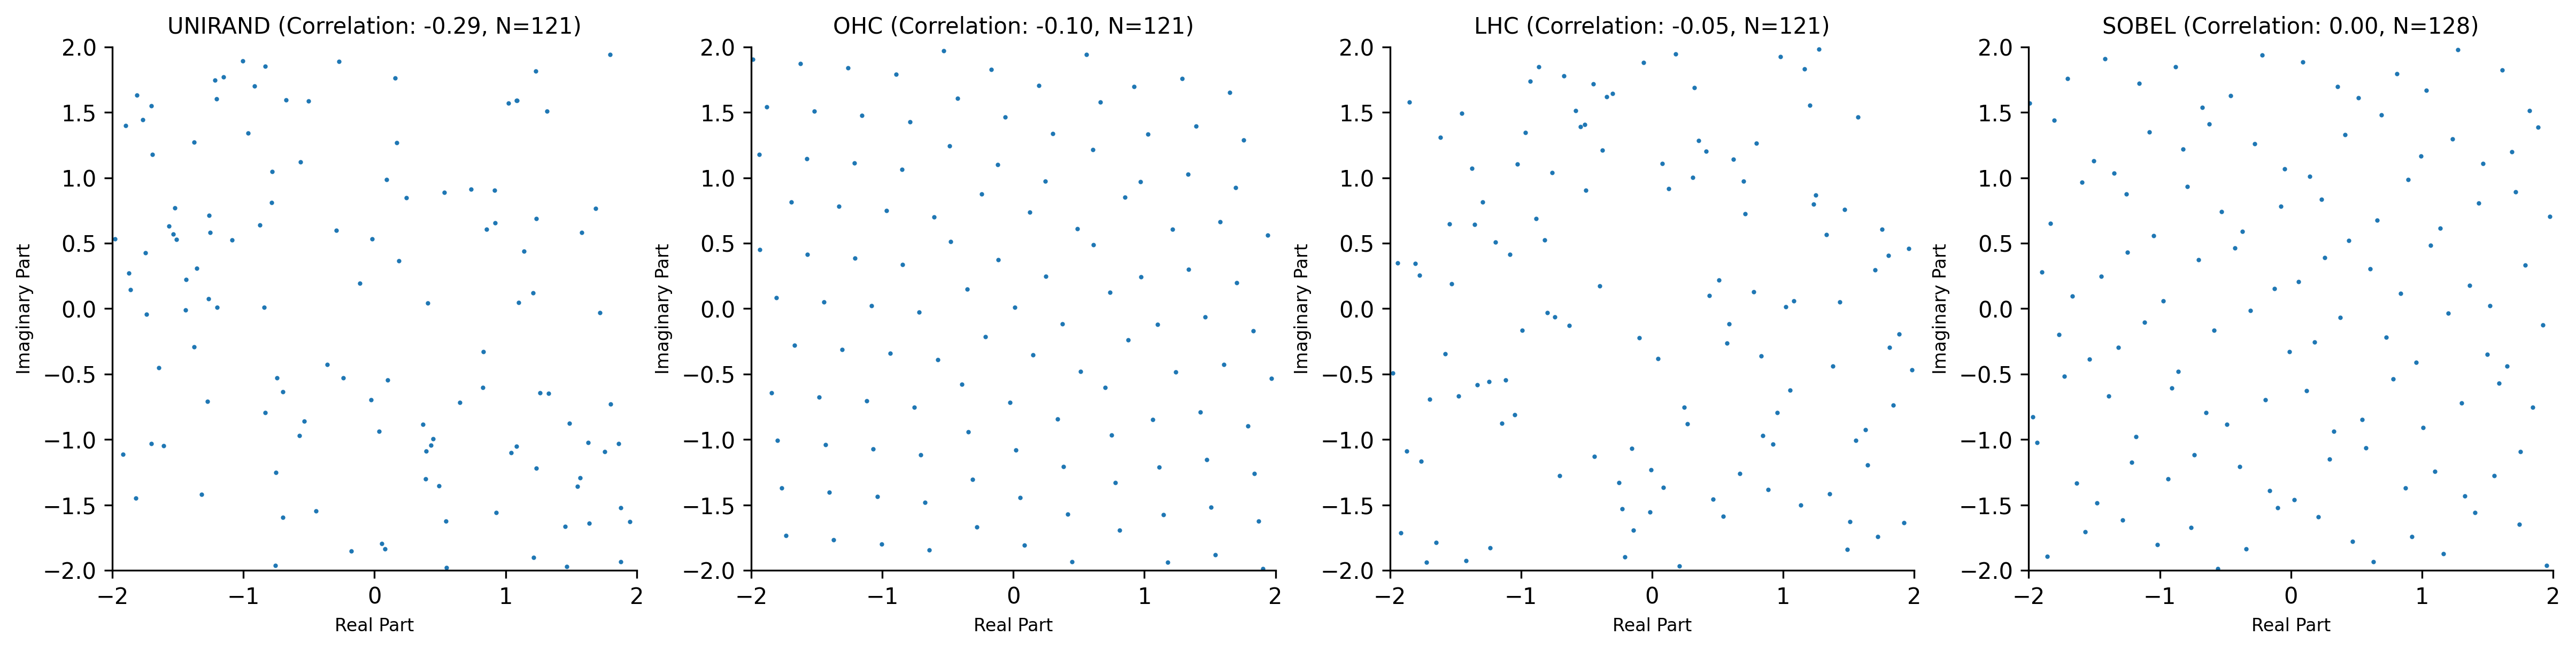

In [112]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=300)  # Single row of 4 plots, smaller height
axs = axs.flatten()

for i, method in enumerate(methods):
    c_re, c_im = samples[method]
    correlation = correlations[method]
    axs[i].scatter(c_re, c_im, s=1)
    axs[i].set_title(f"{method} (Correlation: {correlation:.2f}, N={num_samples[method]})", fontsize=10)
    axs[i].set_xlabel("Real Part", fontsize=8)
    axs[i].set_ylabel("Imaginary Part", fontsize=8)
    axs[i].set_xlim([-2, 2])
    axs[i].set_ylim([-2, 2])
    
    # Hide top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

# Adjust layout for compactness
plt.tight_layout(pad=0.5)  # Reduces padding around the plots
plt.savefig('Report Plots/sampling_correlations_1by4.png', dpi=dpi)


### Monte Carlo Integration

In [8]:
def monte_carlo(sample_range, num_iterations, max_length_set, re_min, re_max, im_min, im_max, sampling_method, seed_scramble):
    all_iterations = np.zeros((num_iterations, len(sample_range)))

    for l, n_samples in enumerate(sample_range):
        areas = np.zeros(num_iterations)
        area_integration_box = np.abs(re_max - re_min) * np.abs(im_max - im_min)
        sampling = np.zeros((num_iterations, n_samples, 3))  # Initialize with zeros for proper shape

        for i in range(num_iterations):
            sampler = MBSampler(re_min=re_min, re_max=re_max, im_min=im_min, im_max=im_max)
            c_array, c_re, c_im = sampler.sample(method=sampling_method, num_samples=n_samples, seed=i + seed_scramble)

            points_outside = 0
            for j in range(n_samples):
                z = complex(0, 0)

                for k in range(max_length_set):
                    z = mandelbrot(z, c_array[j])
                    if magnitude_complex(z) > 2:
                        points_outside += 1
                        sampling[i, j, :] = [c_re[j], c_im[j], 0]
                        break
                else:
                    sampling[i, j, :] = [c_re[j], c_im[j], 1]  # Mark as inside if it doesn't break

            areas[i] = area_integration_box * (1 - (points_outside / n_samples))

        all_iterations[:, l] = areas

    return all_iterations, sampling


In [28]:
sample_range = np.array([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43])**2
sobol_sample = sobol_sample_sizes_generator(10)

In [39]:
area_mc_sampling = monte_carlo(sample_range, 50, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='UNIRAND', seed_scramble=100)

In [34]:
all_iterations, samples = area_mc_sampling

In [35]:
# Take a single sample from Monte Carlo
sample = samples[0]  
x0, y0 = zip(*[ [x, y] for x, y in sample[sample[:, 2] == 1, :2] ]) #suggestion x0 = mc_in_area_x etc.
x1, y1 = zip(*[ [x, y] for x, y in sample[sample[:, 2] == 0, :2] ]) #suggestion x1 = mc_out_area_x etc.

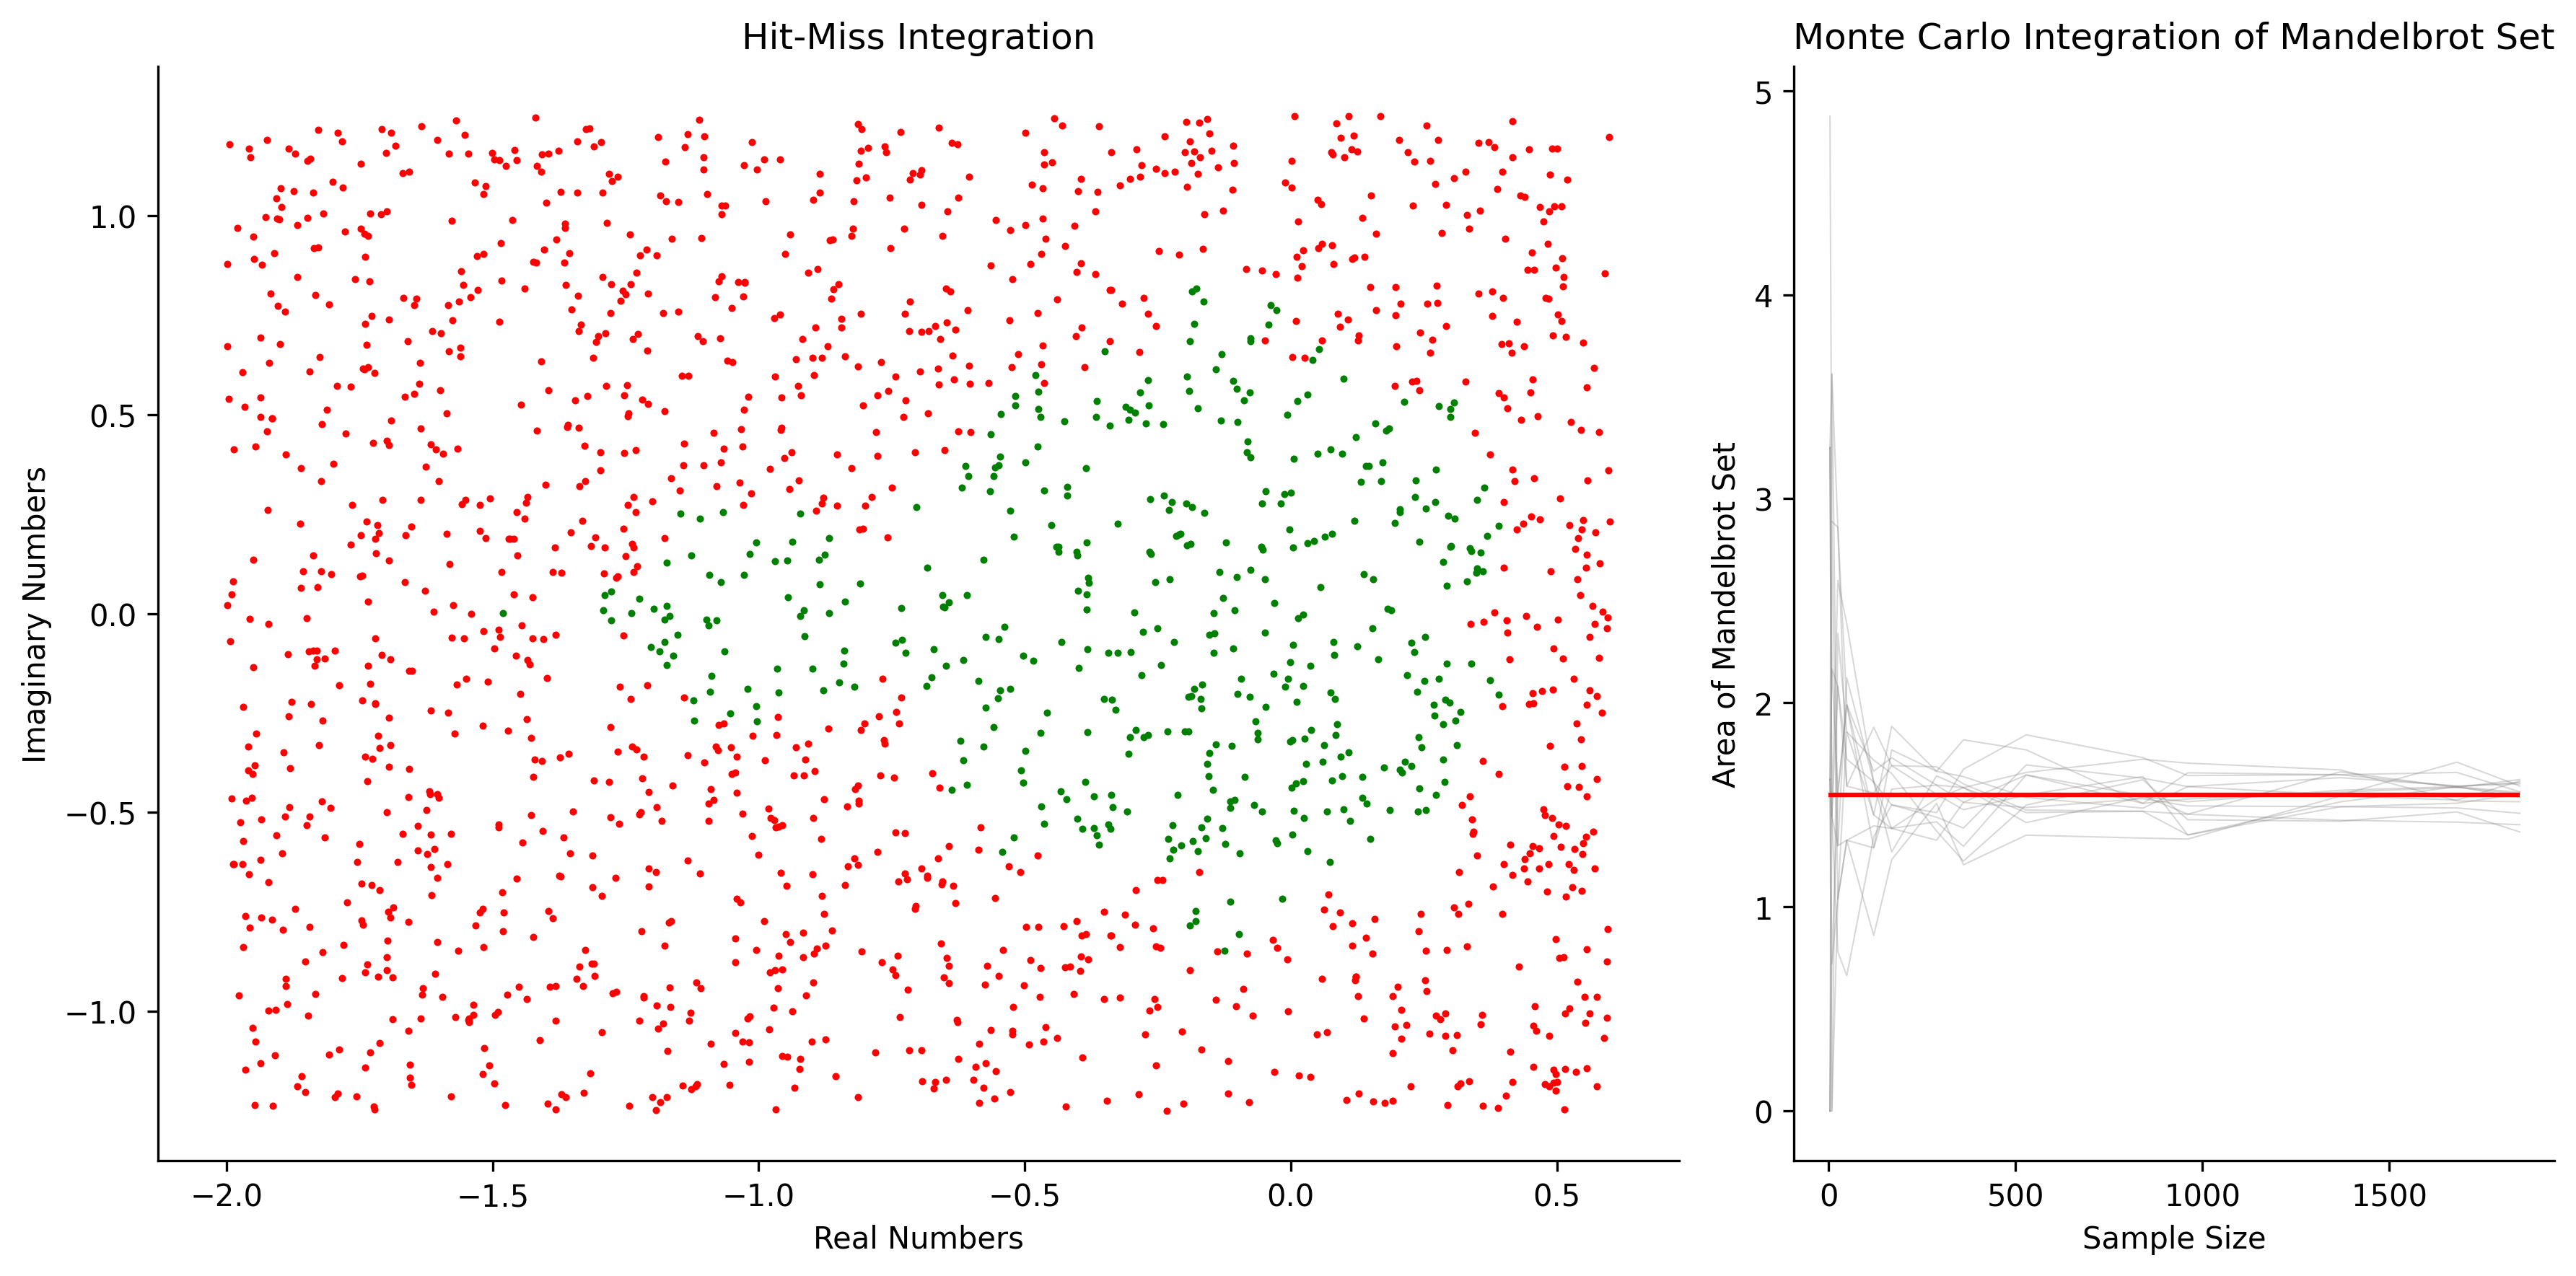

In [ ]:
# Create a figure and use GridSpec to control the plot size ratios
fig = plt.figure(figsize=(12, 6), dpi=300)
gs = GridSpec(1, 2, width_ratios=[2, 1], figure=fig)  # Set width ratio to make second plot smaller

# Subplot 1: Line plot for infection peak reduction
ax1 = fig.add_subplot(gs[0])
ax1.scatter(x = x0, y= y0, color = 'green', s=2)
ax1.scatter(x = x1, y= y1, color = 'red', s=2)

ax1.set_title('Hit-Miss Integration', fontsize=12)
ax1.set_xlabel('Real Numbers')  # real axis
ax1.set_ylabel('Imaginary Numbers') # imaginary axis

ax2 = fig.add_subplot(gs[1])
for i in range(len(sample_range)):
    ax2.plot(sample_range, all_iterations[i], alpha=0.3, color = 'grey', lw =0.5)
#ax2.clabel(contours, inline=True, fontsize=8)
ax2.hlines(np.mean(all_iterations[:,-1]), xmin=0, xmax=(sample_range[-1]), color = 'red') #mby de echte opzoeken op het internet)

ax2.set_ylabel("Area of Mandelbrot Set")
ax2.set_xlabel("Sample Size")
ax2.set_title("Monte Carlo Integration of Mandelbrot Set")

# Remove unnecessary spines from both subplots
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure with high resolution (300 DPI)
plt.savefig('Report Plots/hit_miss_unirand.png', dpi=dpi)
plt.show()

Next, we calculate a reference value of the area for a large sample size. Because this takes very long, the number of iterations is set to 100. Since random, lhc, and orthogonal can all use prime numbers, we use $127^2 = 16129$. To make a reasonable comparison to sobol sampling, we use $2^{14} = 16129$, which is the closest power of 2. Keep in mind that the cell below takes roughly 10 minutes to complete. The results of this cell are:

UNIRAND: Area at 16129 samples is: 1.546946803893608

LHC: Area at 16129 samples is: 1.5478938557877118

Orthogonal: Area at 16129 samples is: 1.545971541943084

Sobol: Area at 16384 samples is: 1.5458010864257812

In [14]:
large_prime_sample = 127**2
large_sobol_sample = 2**14

large_sample_random = np.mean(monte_carlo([large_prime_sample], 100, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='UNIRAND', seed_scramble=100)[0][:, -1])
large_sample_LHC = np.mean(monte_carlo([large_prime_sample], 100, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='LHC',seed_scramble=100)[0][:, -1])
large_sample_OS = np.mean(monte_carlo([large_prime_sample], 100, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='OHC', seed_scramble=100)[0][:, -1])
large_sample_sobol = np.mean(monte_carlo([large_sobol_sample], 100, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='SOBEL',seed_scramble=100)[0][:, -1])

print(f'UNIRAND: Area at {large_prime_sample} samples is: {large_sample_random}')
print(f'LHC: Area at {large_prime_sample} samples is: {large_sample_LHC}')
print(f'Orthogonal: Area at {large_prime_sample} samples is: {large_sample_OS}')
print(f'Sobol: Area at {large_sobol_sample} samples is: {large_sample_sobol}')

UNIRAND: Area at 16129 samples is: 1.546946803893608
LHC: Area at 16129 samples is: 1.5478938557877118
Orthogonal: Area at 16129 samples is: 1.545971541943084
Sobol: Area at 16384 samples is: 1.5458010864257812


We also want to test how many iterations we need to get a good result. We want to study $A_{j,s} - A_{i,s}$ where $j < i$ are the number of iterations. We set $i=1000$ and test values for $j$ while keeping the number of samples equal to $31^2 = 961$ for prime sampling and $2^{10} = 1024$ for sobol sampling. Since the number of iterations is quite large, the cell below takes long to run.

In [37]:
iteration_range = [10, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500, 600, 700]

random_baseline = np.mean(monte_carlo([961], 1000, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='UNIRAND', seed_scramble=100)[0][:, -1])
LHC_baseline = np.mean(monte_carlo([961], 1000, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='LHC',seed_scramble=100)[0][:,-1])
OS_baseline = np.mean(monte_carlo([961], 1000, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='OHC', seed_scramble=100)[0][:, -1])
sobol_baseline = np.mean(monte_carlo([1024], 1000, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='SOBEL',seed_scramble=100)[0][:, -1])

def calculate_difference(baseline, method):
    deltas = []

    for i in iteration_range:
        if method == 'SOBEL':
            area_j = np.mean(monte_carlo([1024], i, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method=method, seed_scramble=100)[0][:, -1])
        else:
            area_j = np.mean(monte_carlo([961], i, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method=method, seed_scramble=100)[0][:, -1])

        delta = area_j - baseline
        deltas.append(delta)
    
    return deltas

In [38]:
deltas_random = calculate_difference(random_baseline, 'UNIRAND')
deltas_LHC = calculate_difference(LHC_baseline, 'LHC')
deltas_OS = calculate_difference(OS_baseline, 'OHC')
deltas_sobol = calculate_difference(sobol_baseline, 'SOBEL')

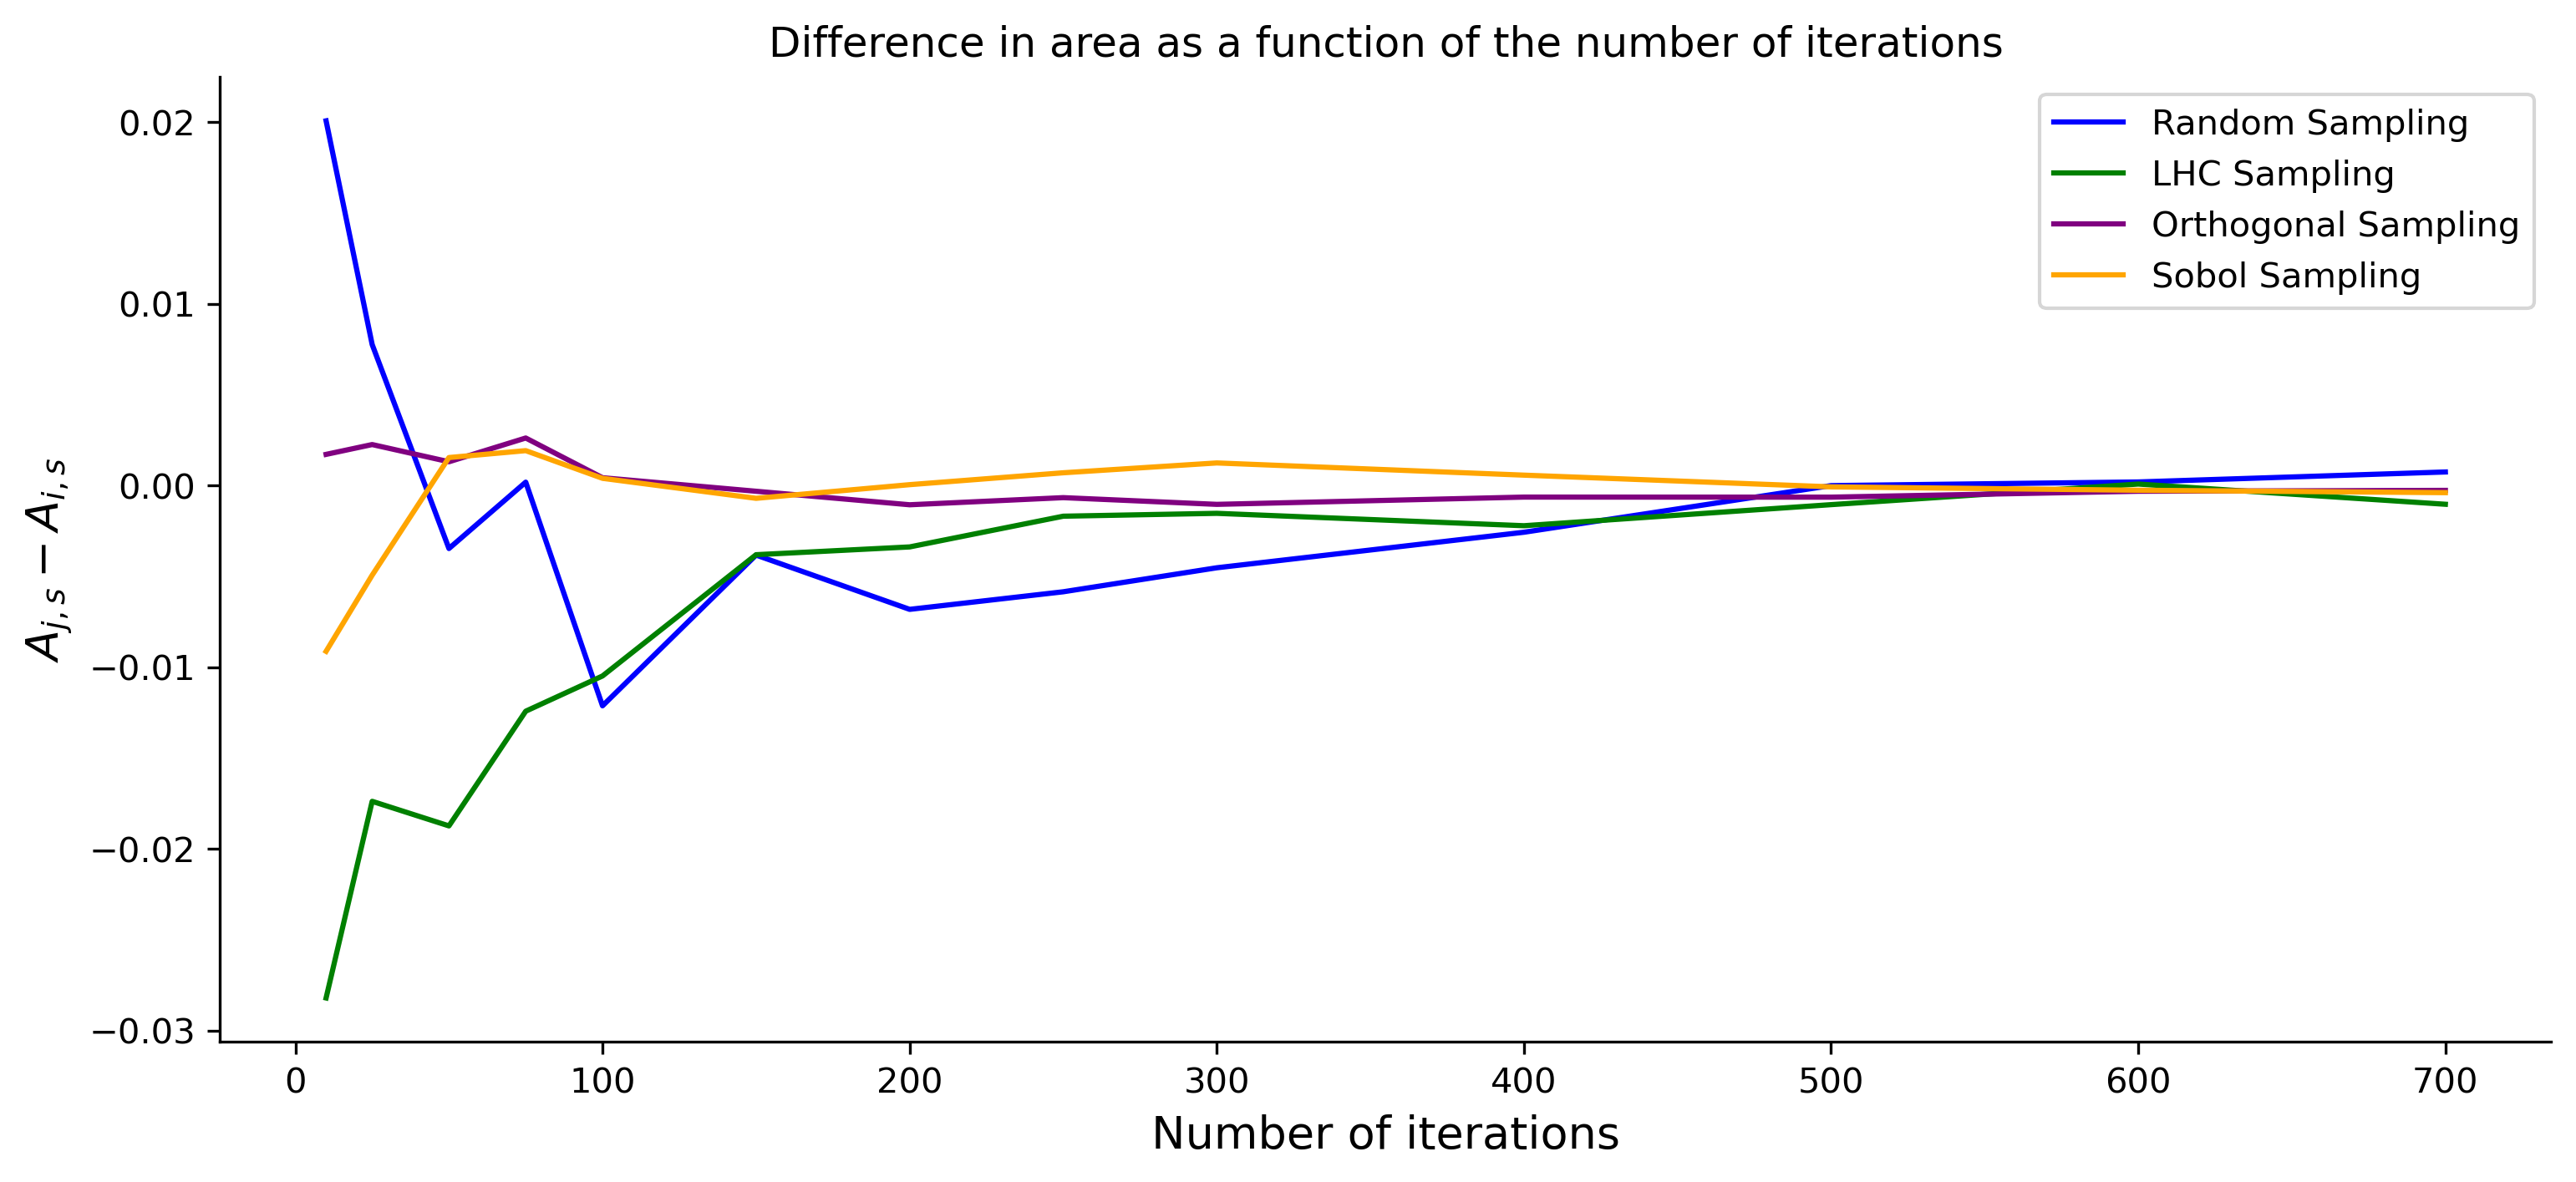

<Figure size 640x480 with 0 Axes>

In [39]:
plt.figure(figsize=(12, 5), dpi=300)

plt.plot(iteration_range, deltas_random, color='blue', label='Random Sampling')
plt.plot(iteration_range, deltas_LHC, color='green', label='LHC Sampling')
plt.plot(iteration_range, deltas_OS, color='purple', label='Orthogonal Sampling')
plt.plot(iteration_range, deltas_sobol, color='orange', label='Sobol Sampling')
plt.xlabel('Number of iterations', fontsize=13)
plt.ylabel(r'$A_{j,s} - A_{i, s}$', fontsize=13)
plt.title('Difference in area as a function of the number of iterations')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()
plt.show()
plt.savefig('Report Plots/iteration_comparison.png', dpi=dpi)

In [40]:
# Square of primes: 47**2 ~ 2200 samples, 2**11 ~ 2000 samples
sample_range = np.array([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47])**2
sobol_sample = sobol_sample_sizes_generator(11)

random, _ = monte_carlo(sample_range, 500, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='UNIRAND', seed_scramble=100)
LHC, _ = monte_carlo(sample_range, 500, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='LHC',seed_scramble=100)
OS, _ = monte_carlo(sample_range, 500, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='OHC', seed_scramble=100)
sobol, _ = monte_carlo(sobol_sample, 500, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='SOBEL',seed_scramble=100)

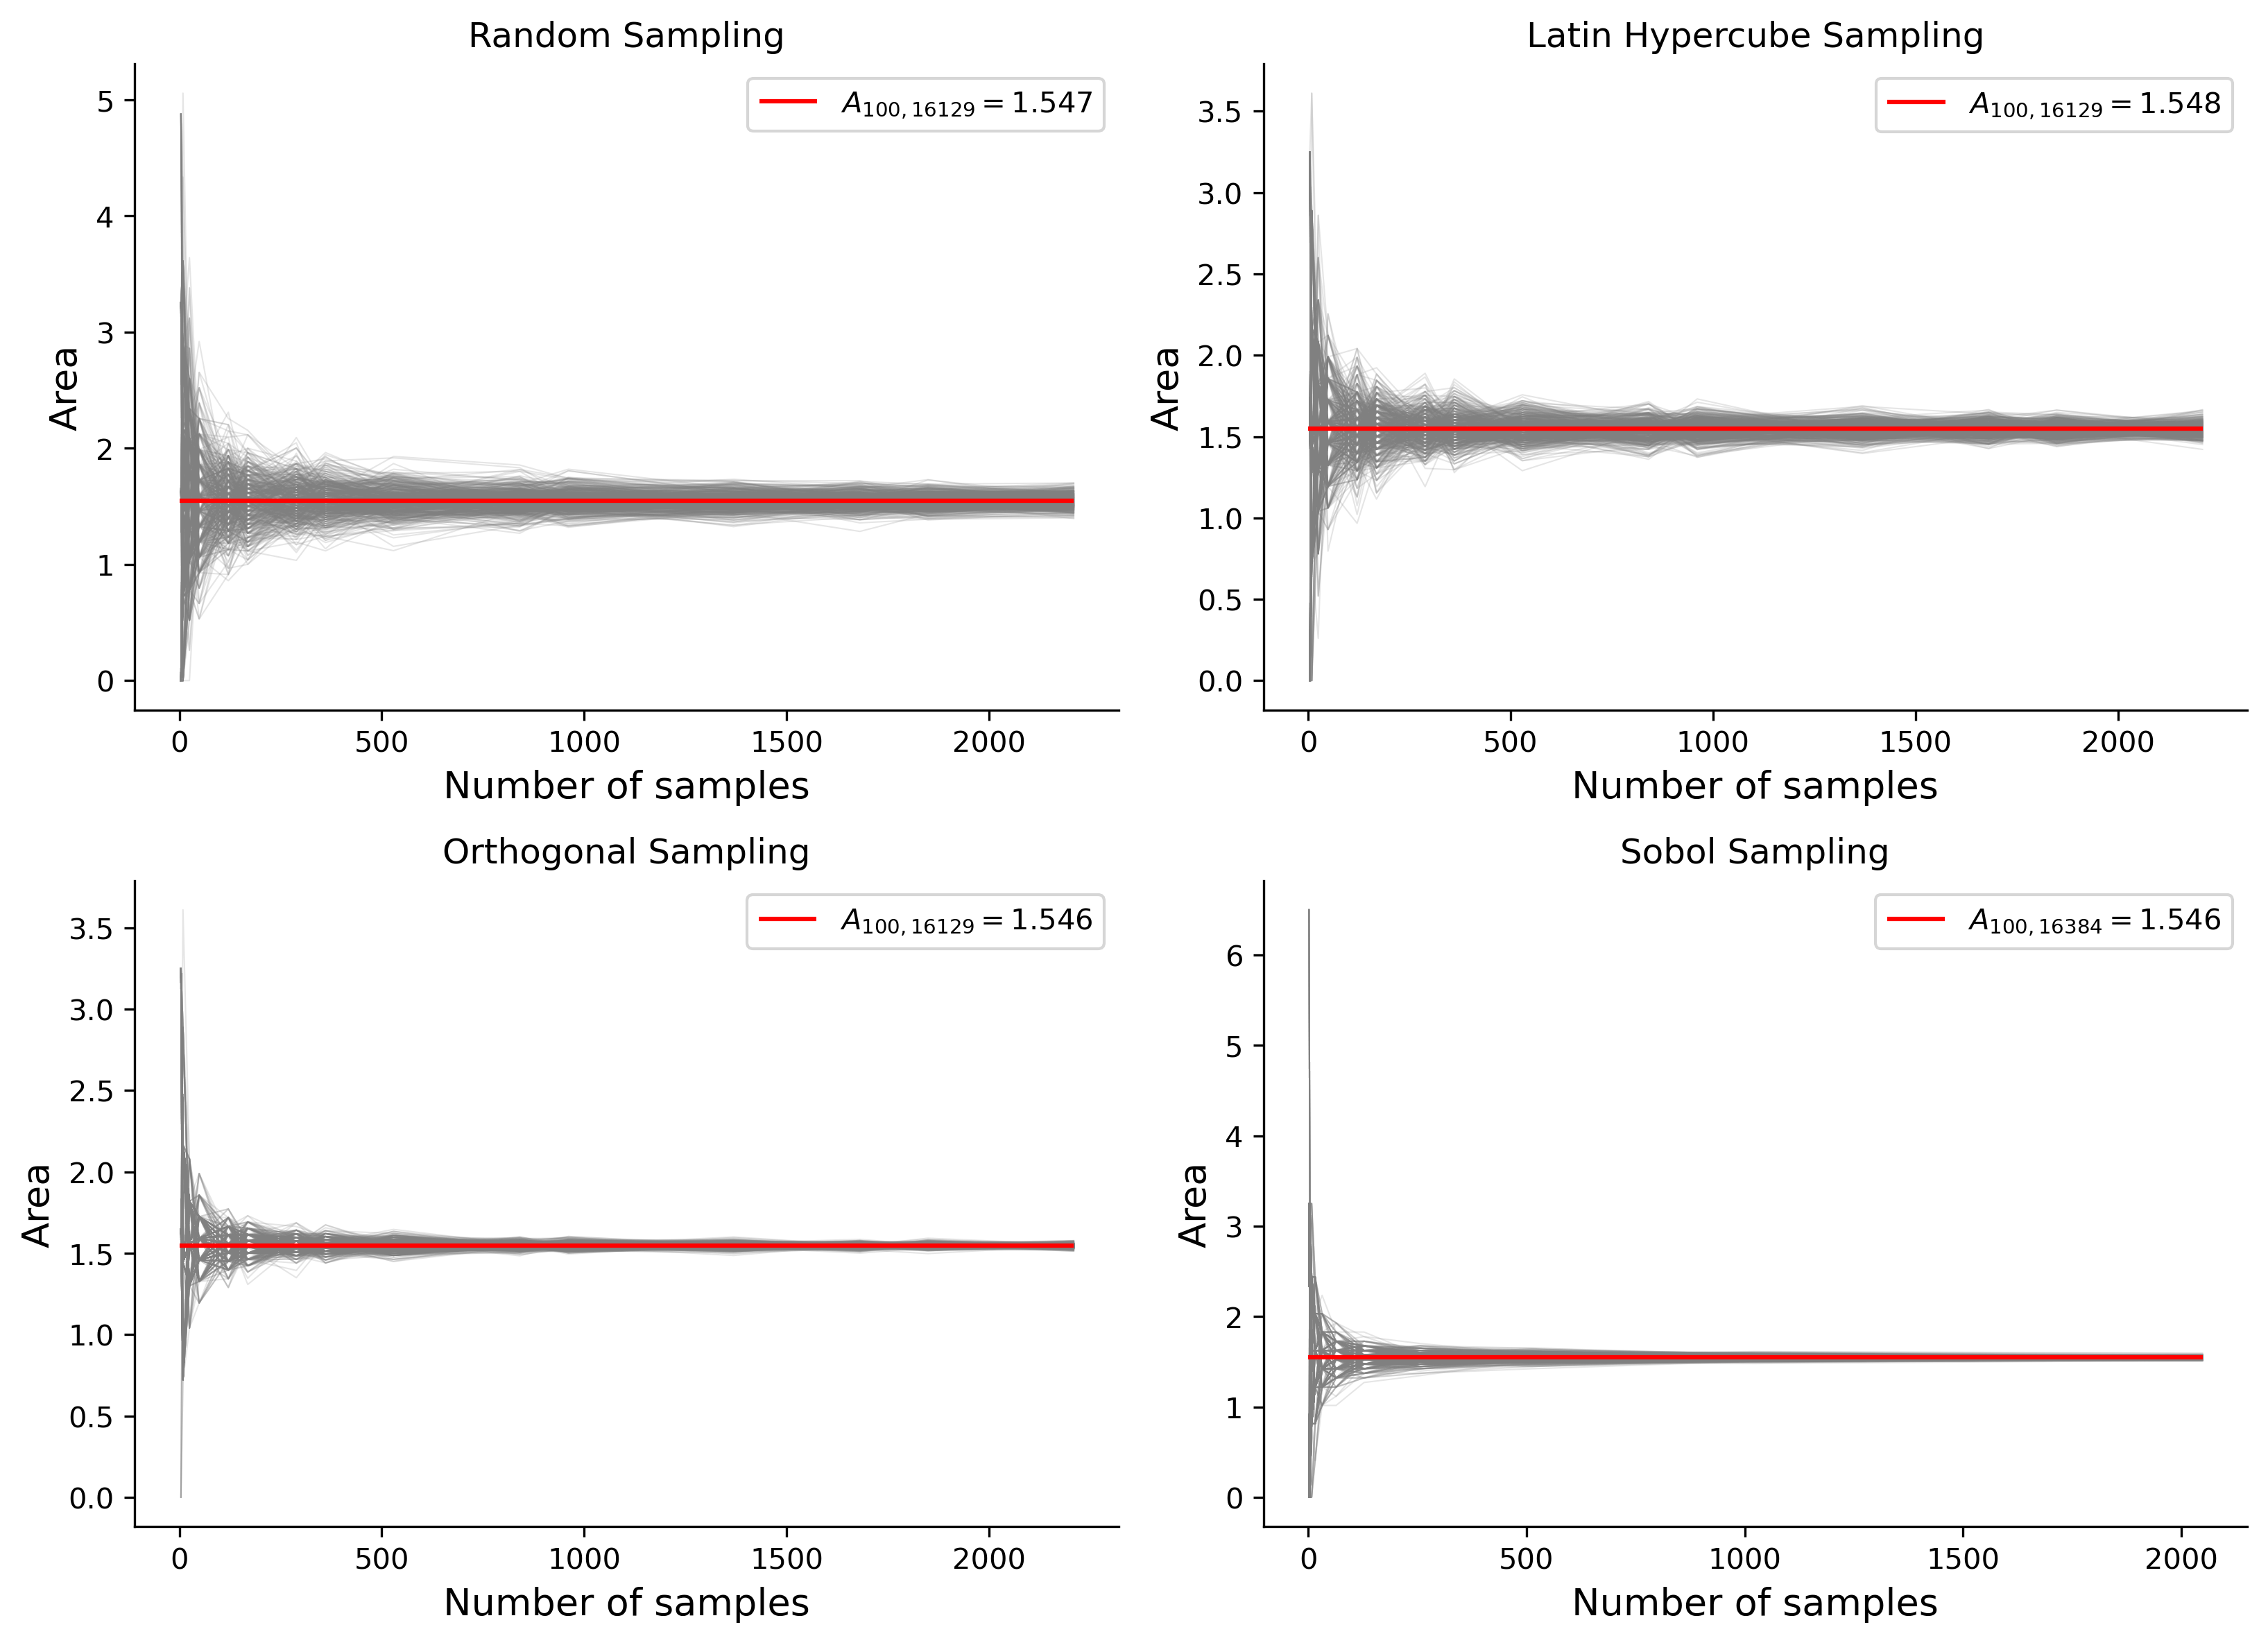

In [41]:
plt.figure(figsize=(11,8), dpi=300)

plt.subplot(2,2,1)
plt.title('Random Sampling')
for i in range(len(random)):
	plt.plot(sample_range, random[i, :], color='gray', lw=0.5, alpha=0.2)
plt.hlines(large_sample_random, xmin=0, xmax=sample_range[-1], color='red', label=fr'$A_{{100,16129}} = {round(large_sample_random, 3)}$')
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()

plt.subplot(2,2,2)
plt.title('Latin Hypercube Sampling')
for i in range(len(LHC)):
	plt.plot(sample_range, LHC[i, :], color='gray', lw=0.5, alpha=0.2)
plt.hlines(large_sample_LHC, xmin=0, xmax=sample_range[-1], color='red', label=fr'$A_{{100,16129}} = {round(large_sample_LHC, 3)}$')
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()

plt.subplot(2,2,3)
plt.title('Orthogonal Sampling')
for i in range(len(OS)):
	plt.plot(sample_range, OS[i, :], color='gray', lw=0.5, alpha=0.2)
plt.hlines(large_sample_OS, xmin=0, xmax=sample_range[-1], color='red', label=fr'$A_{{100,16129}} = {round(large_sample_OS, 3)}$')
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()

plt.subplot(2,2,4)
plt.title('Sobol Sampling')
for i in range(len(sobol)):
	plt.plot(sobol_sample, sobol[i, :], color='gray', lw=0.5, alpha=0.2)
plt.hlines(large_sample_sobol, xmin=0, xmax=sobol_sample[-1], color='red', label=fr'$A_{{100,16384}} = {round(large_sample_sobol, 3)}$')
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()

plt.tight_layout()
#plt.show()
plt.savefig('Report Plots/sampling_compairson_long_run.png', dpi=dpi)

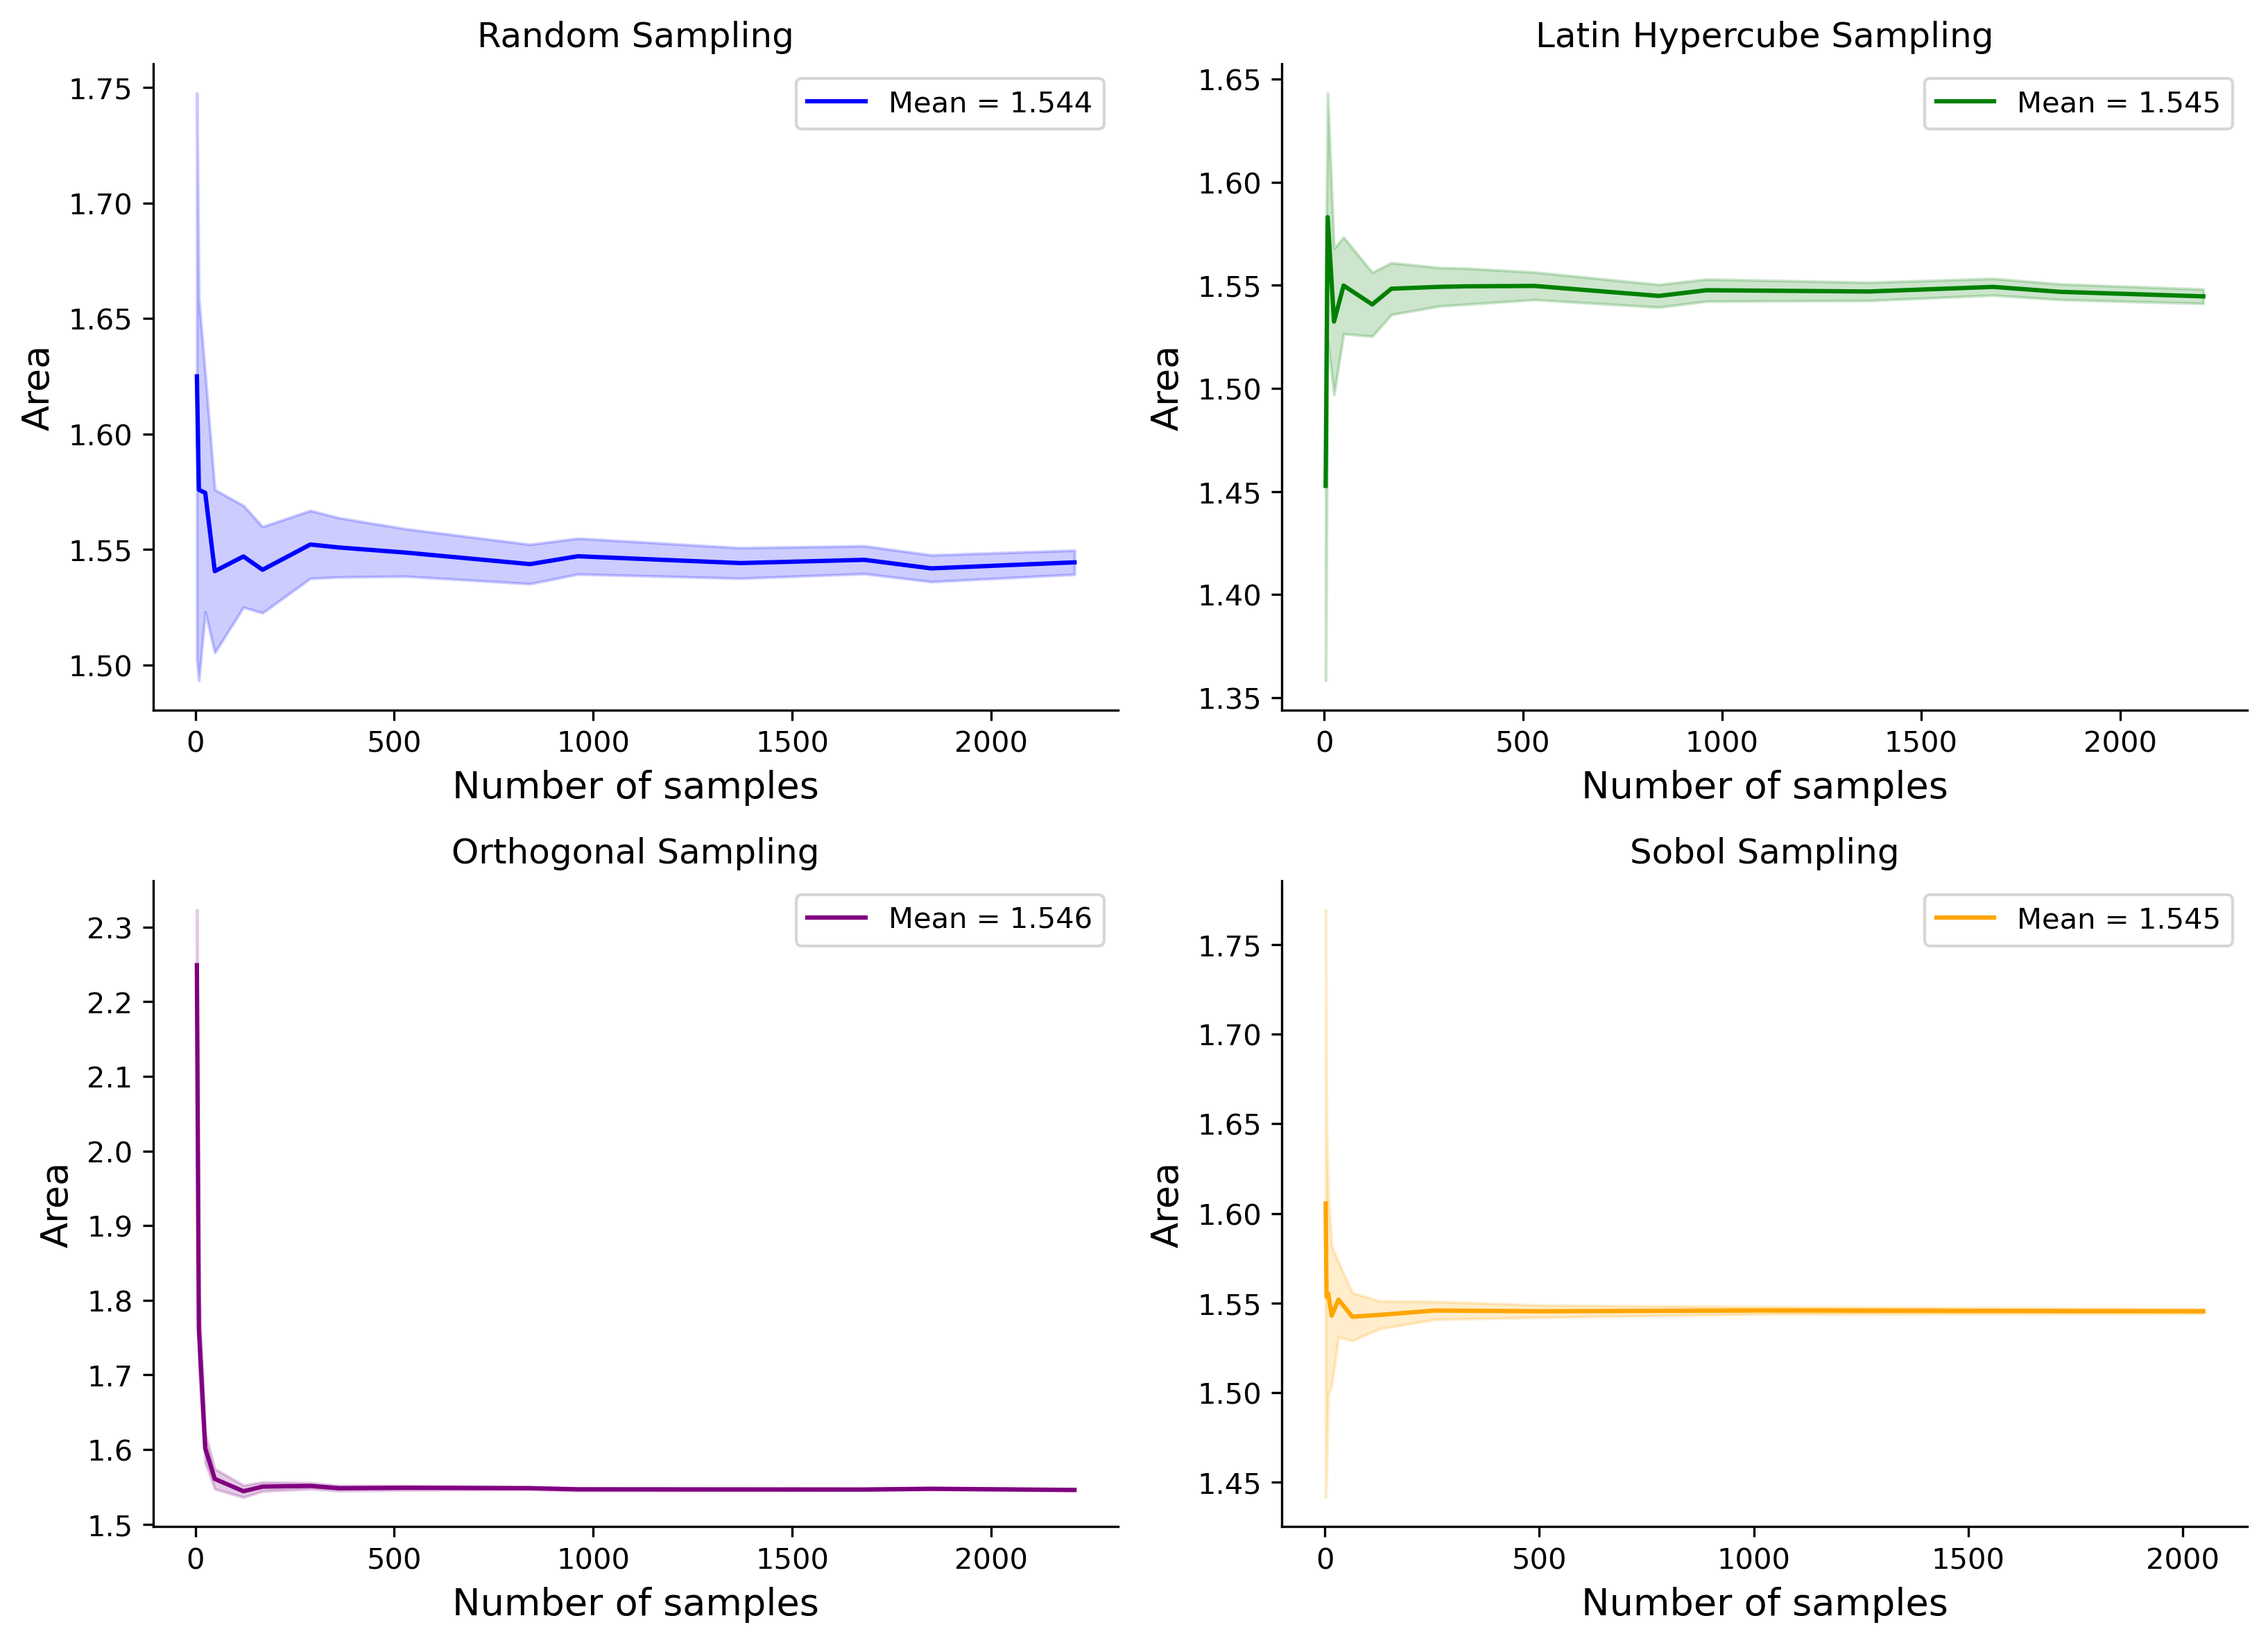

In [42]:
# Calculate means and standard errors for each sampling method
mean_area_random = np.mean(random[:, -1])
mean_random = np.mean(random, axis=0)
std_error_random = np.std(random, axis=0) / np.sqrt(random.shape[0])

mean_area_LHC = np.mean(LHC[:, -1])
mean_LHC = np.mean(LHC, axis=0)
std_error_LHC = np.std(LHC, axis=0) / np.sqrt(LHC.shape[0])

mean_area_OS = np.mean(OS[:, -1])
mean_OS = np.mean(OS, axis=0)
std_error_OS = np.std(OS, axis=0) / np.sqrt(OS.shape[0])

mean_area_SOBOL = np.mean(sobol[:, -1])
mean_sobol = np.mean(sobol, axis=0)
std_error_sobol = np.std(sobol, axis=0) / np.sqrt(sobol.shape[0])

plt.figure(figsize=(11, 8), dpi=300)

# Random Sampling
plt.subplot(2, 2, 1)
plt.title('Random Sampling')
plt.plot(sample_range, mean_random, color='blue', label=f'Mean = {round(mean_area_random, 3)}')
plt.fill_between(sample_range, mean_random - 2*std_error_random, mean_random + 2*std_error_random, color='blue', alpha=0.2)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Latin Hypercube Sampling
plt.subplot(2, 2, 2)
plt.title('Latin Hypercube Sampling')
plt.plot(sample_range, mean_LHC, color='green', label=f'Mean = {round(mean_area_LHC, 3)}')
plt.fill_between(sample_range, mean_LHC - 2*std_error_LHC, mean_LHC + 2*std_error_LHC, color='green', alpha=0.2)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Orthogonal Sampling
plt.subplot(2, 2, 3)
plt.title('Orthogonal Sampling')
plt.plot(sample_range, mean_OS, color='purple', label=f'Mean = {round(mean_area_OS, 3)}')
plt.fill_between(sample_range, mean_OS - 2*std_error_OS, mean_OS + 2*std_error_OS, color='purple', alpha=0.2)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Sobol Sampling
plt.subplot(2, 2, 4)
plt.title('Sobol Sampling')
plt.plot(sobol_sample, mean_sobol, color='orange', label=f'Mean = {round(mean_area_SOBOL, 3)}')
plt.fill_between(sobol_sample, mean_sobol - 2*std_error_sobol, mean_sobol + 2*std_error_sobol, color='orange', alpha=0.2)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

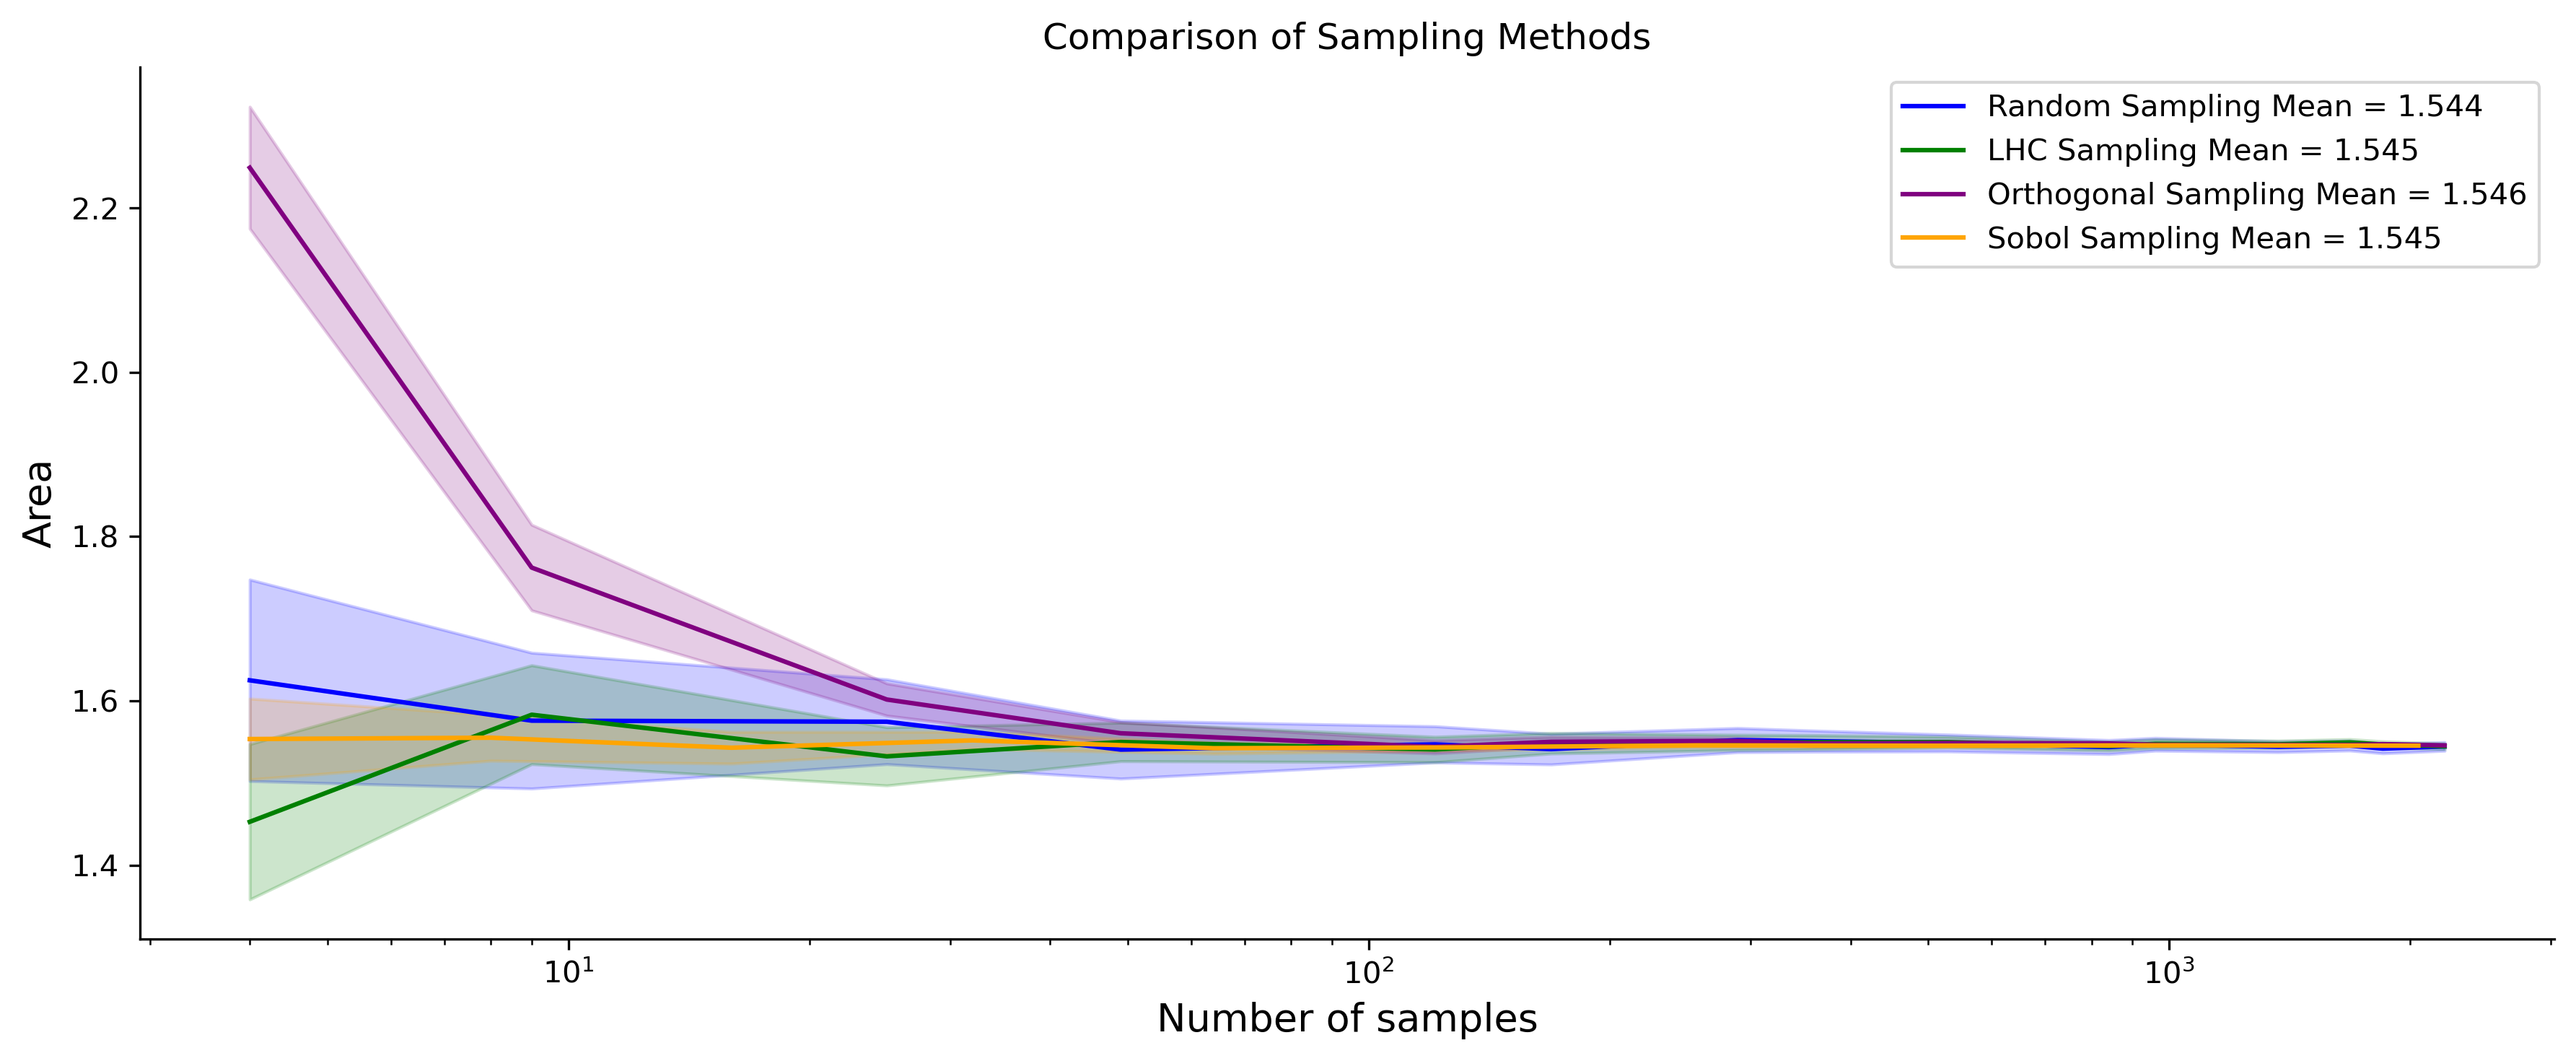

In [43]:
# Plot all in one figure
plt.figure(figsize=(12, 5), dpi=300)

# Random Sampling
plt.plot(sample_range, mean_random, color='blue', label=f'Random Sampling Mean = {round(mean_area_random, 3)}')
plt.fill_between(sample_range, mean_random - 2*std_error_random, mean_random + 2*std_error_random, color='blue', alpha=0.2)

# Latin Hypercube Sampling
plt.plot(sample_range, mean_LHC, color='green', label=f'LHC Sampling Mean = {round(mean_area_LHC, 3)}')
plt.fill_between(sample_range, mean_LHC - 2*std_error_LHC, mean_LHC +  2*std_error_LHC, color='green', alpha=0.2)

# Orthogonal Sampling
plt.plot(sample_range, mean_OS, color='purple', label=f'Orthogonal Sampling Mean = {round(mean_area_OS, 3)}')
plt.fill_between(sample_range, mean_OS - 2*std_error_OS, mean_OS + 2*std_error_OS, color='purple', alpha=0.2)

# Sobol Sampling
plt.plot(sobol_sample[1:], mean_sobol[1:], color='orange', label=f'Sobol Sampling Mean = {round(mean_area_SOBOL, 3)}')
plt.fill_between(sobol_sample[1:], mean_sobol[1:] - std_error_sobol[1:], mean_sobol[1:] + std_error_sobol[1:], color='orange', alpha=0.2)

# Adding labels, title, and legend
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.title('Comparison of Sampling Methods')
plt.xscale('log')
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()
plt.show()